In [1]:
import sys
import os
# Add the 'scripts/' directory to the system path
sys.path.append(os.path.abspath('../triple_mbhb'))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import Kickrateplots as kickplots
import ejectionplots as ejectplots
import astropy.units as u
from astropy import constants as const

import count_vkicks as kickcount
import count_ejections as ejects

In [ ]:
# import Trip_utils as util
# import numpy as np
# import Triple_dynamics as Tr
# import spin_models as spin
# import matplotlib.pyplot as plt
# from tqdm import tqdm
# import Trip_utils as util
# import Kickrateplots as kickplots
# import merger_rate_calculate as mr
# from scipy.stats import binned_statistic

In [ ]:
# import astropy.units as u
# from astropy import constants as const

# import BH_kicks as kick
# import spin_models as spin
# import count_vkicks as kickcount
# import count_ejections as ejects

In [2]:
import os
tex_path = '/apps/texlive/2023/bin/x86_64-linux/'
os.environ['PATH'] += os.pathsep + tex_path

In [4]:
import scienceplots
plt.style.use('science')

In [5]:
# def set_plot_style(linewidth=3, titlesize=20,labelsize=25,ticksize=20,legendsize=20,bold=True):
#         """Set matplotlib rcParams for consistent plot style."""
#         font_weight = 'bold' if bold else 'normal'

#         plt.rcParams.update({
#             'lines.linewidth': linewidth,
#             'axes.labelsize': labelsize,
#             'axes.titlesize': titlesize,
#             'xtick.labelsize': ticksize,
#             'ytick.labelsize': ticksize,
#             'legend.fontsize': legendsize,
#             'axes.titleweight': font_weight,
#             'axes.labelweight': font_weight,
#             'font.weight': font_weight,
#         })


## Spin model distributions

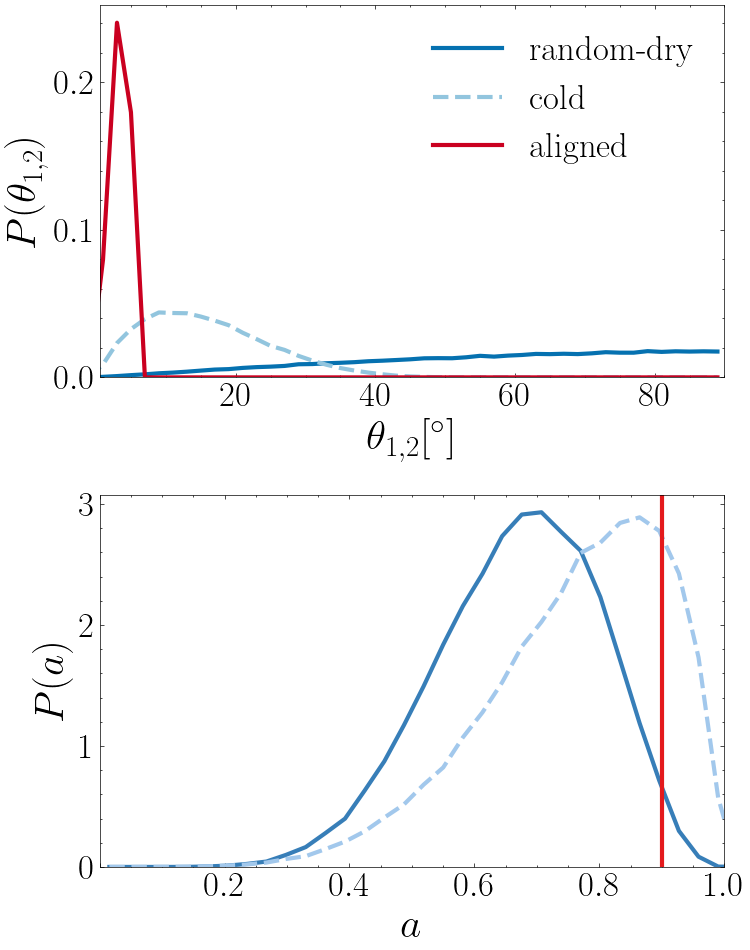

In [8]:
kickplots.set_plot_style(linewidth=3,labelsize=30,legendsize=25,ticksize=25)

fig,axes = kickplots.plot_spin_dist()
fig.savefig("../Figures/spin-models-magnitude-and-angle.pdf")

## Velocity distribution

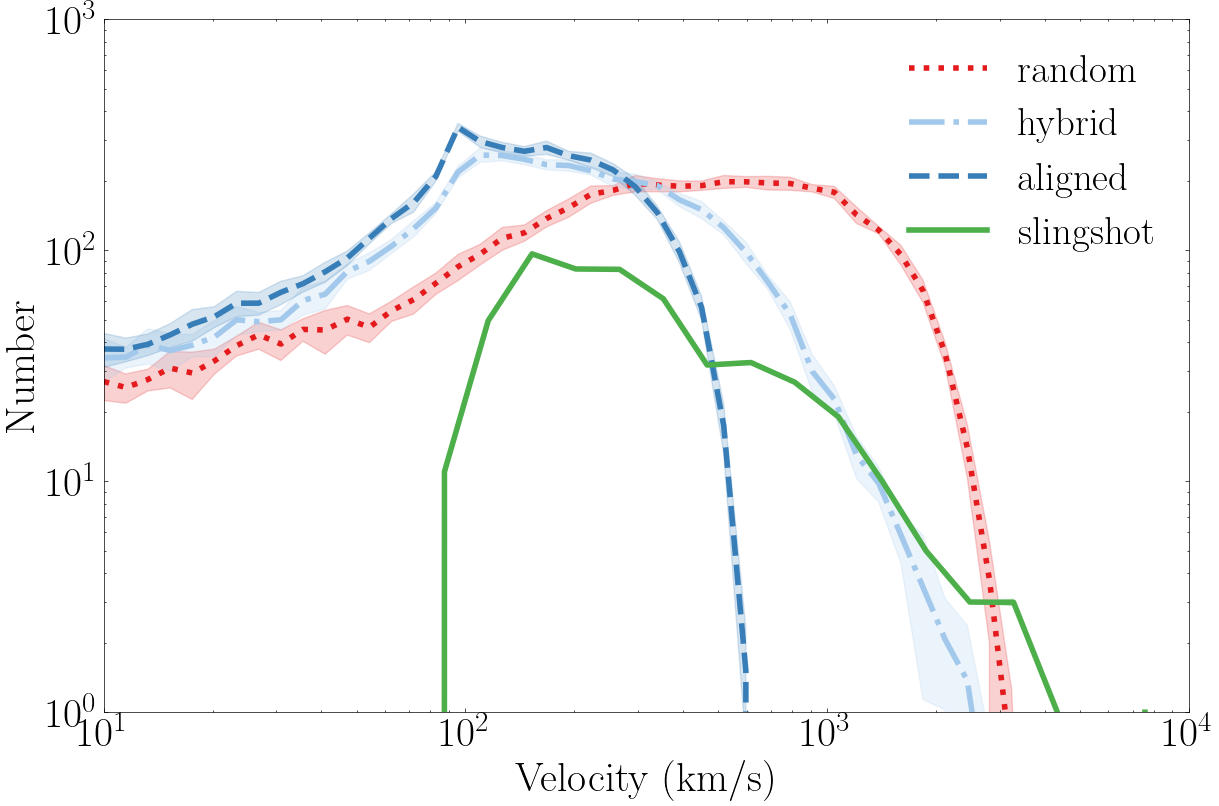

In [8]:
kickplots.set_plot_style(linewidth=4,labelsize=30,legendsize=28,ticksize=30,bold=True)
fig,ax = kickplots.kick_velocity_distribution(100)
fig.set_size_inches(14,9)
ax.legend(loc='upper right')
fig
fig.savefig("../Figures/v-dist-for-all-kicks.pdf")

## Kick statistics

In [9]:
max,med,percentile = kickplots.kick_statistics(Nruns=100)

The maximum kick produced by GW recoil using random spins is 3519.10 ± 7.79 km/s
The maximum kick produced by GW recoil using aligned spins is 629.01 ± 0.38 km/s
The maximum kick produced by GW recoil using hybrid spins is 3087.83 ± 8.95 km/s
The maximum kick produced by slingshot using random spins is 8368.36 ± 0.00 km/s
--------
The median kick produced by GW recoil using random spins is 313.91 ± 0.07 km/s
The median kick produced by GW recoil using aligned spins is 111.87 ± 0.01 km/s
The median kick produced by GW recoil using hybrid spins is 143.21 ± 0.02 km/s
The median kick produced by slingshot using random spins is 282.90 ± 0.09 km/s
--------
The % of kicks above 500 in random model is 36.36 ± 0.54 %
The % of kicks above 500 in hybrid model is 10.24 ± 0.28 %
The % of kicks above 500 in aligned model is 0.64 ± 0.11 %
The % of kicks above 500 in slingshot model is 24.10 ± 0.14 %
----------
The % of kicks above 1000 in random model is 15.58 ± 0.47 %
The % of kicks above 1000 in hy

In [6]:
Nruns = 100
strong_tr, weak_tr, iso_bin, stalled_objs = kickplots.import_objects(Nruns)

In [7]:
v_min = 1269
v_max = 9000
kickplots.count_kicks_in_range(v_min,v_max,Nruns,iso_bin,weak_tr,strong_tr)

The number of kicks in the 1269-9000 km/s range for random spins is 4300.56
The number of kicks in the 1269-9000 km/s range for hybrid spins is 298.94
The number of kicks in the 1269-9000 km/s range for aligned spins is 0.0
The number of kicks in the 1269-9000 km/s range for slingshot is 32.97


{'random': 4300.56, 'hybrid': 298.94, 'aligned': 0.0, 'slingshot': 32.97}

### % of ejected 

In [15]:
kickplots.compute_ejection_percentages(Nruns,iso_bin,weak_tr,strong_tr)

Random ejection percentage: 14.69% ± 0.44%
Hybrid ejection percentage: 1.87% ± 0.12%
Aligned ejection percentage: 0.25% ± 0.06%
Slingshot ejection percentage: 6.72% ± 0.04%


## Ejection rates

In [10]:
merger_rate_path = "../Data/merger_rates/"
Nruns=100

In [13]:
kickplots.set_plot_style(linewidth=4,titlesize=30,labelsize=30,legendsize=28,ticksize=30,bold=True)

calculating combined ejection rates for aligned: 100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


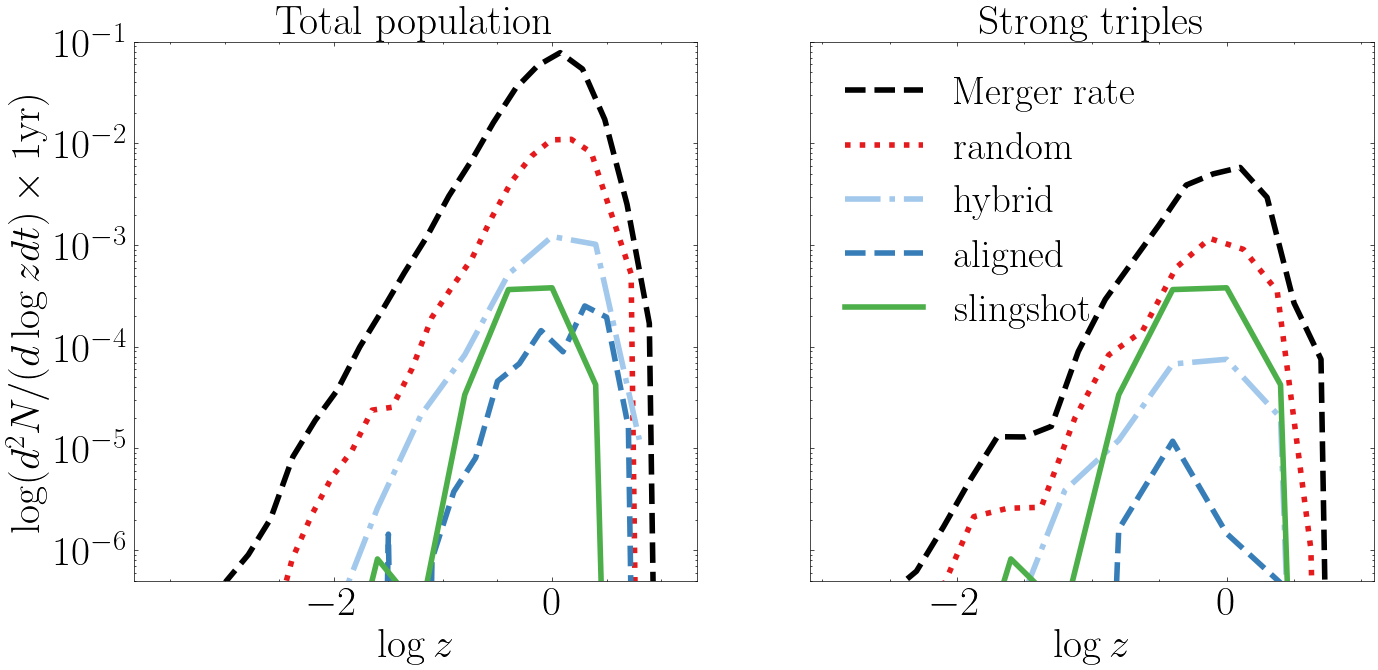

In [11]:
fig,ax = ejectplots.ejection_rates_plot(Nruns,merger_rate_path)

In [16]:
ax[1].legend(fontsize=25)
ax[1].set_xticks([-3,-2,-1,0,1])
ax[0].set_xticks([-3,-2,-1,0,1])
fig
fig.savefig(f"../Figures/ejection_rates_all_and_triples_%d.pdf"%(Nruns))

In [8]:
N_kicks = 10
#assign ejections
ejects.assign_ejection_masks(strong_tr,iso_bin,weak_tr,Nruns)
ejects.calculate_total_number_of_ejections(N_kicks,Nruns,strong_tr,weak_tr,iso_bin)

The average number of slingshot ejections is: 35.0
The average number of random ejections is: 678.8
The average number of hybrid ejections is: 86.4 
The average number of aligned ejections is: 11.7
--------------------
The average number of random ejections in strong triples is: 74.8
The average number of hybrid ejections in strong triples is: 6.8 
The average number of aligned ejections in strong triples is: 0.5


### Merger rates after excluding ejections

In [14]:
ejects.assign_bhids(iso_bin,weak_tr,strong_tr,Nruns)

In [9]:
N_kicks = 10
ejects.summarize_invalid_merger_fractions(strong_tr,weak_tr,iso_bin,N_kicks,Nruns)  

Processing kick realizations:   0%|          | 0/10 [00:00<?, ?it/s]

Processing kick realizations: 100%|██████████| 10/10 [00:01<00:00,  5.25it/s]


6.4% of mergers won't happen due to GW random + slingshot ejections
1.5% of mergers won't happen due to GW hybrid + slingshot ejections
0.1% of mergers won't happen due to GW aligned + slingshot ejections
5.8% of mergers won't happen due to GW random ejections
0.7% of mergers won't happen due to GW hybrid ejections
0.1% of mergers won't happen due to GW aligned ejections
  - Slingshot ejections account for 9.4% of all invalid mergers in random+slingshot


In [8]:
kick_types_all = {
            'random': {'lgzbinsize': 0.25, 'lgzmin': -3, 'lgzmax': 1.0},
            'hybrid': {'lgzbinsize': 0.4, 'lgzmin': -3, 'lgzmax': 1.0},
            'aligned': {'lgzbinsize': 0.4, 'lgzmin': -3, 'lgzmax': 1.0},
            'slingshot': {'lgzbinsize': 0.25, 'lgzmin': -3, 'lgzmax': 1.0}
        }

In [19]:
kick_colors = {'slingshot':"#4daf4a",'aligned':"#377eb8","hybrid":"#a2c8ec","random":"#e41a1c"}

In [39]:
# Example kick types and binsizes
kick_types = ['slingshot', 'random', 'hybrid', 'aligned']
binsizes = {
    'slingshot': 0.95,
    'random': 0.7,
    'hybrid': 0.7,
    'aligned': 0.6
}

lgzmin = -4
lgzmax = 1
Nmergers_thresh = 10


accumulated_fractions, bin_centers = ejects.calculate_fraction_ejection(
    strong_tr, weak_tr, iso_bin, Nruns, N_kick_realization, kick_types, binsizes, lgzmin, lgzmax, Nmergers_thresh
)

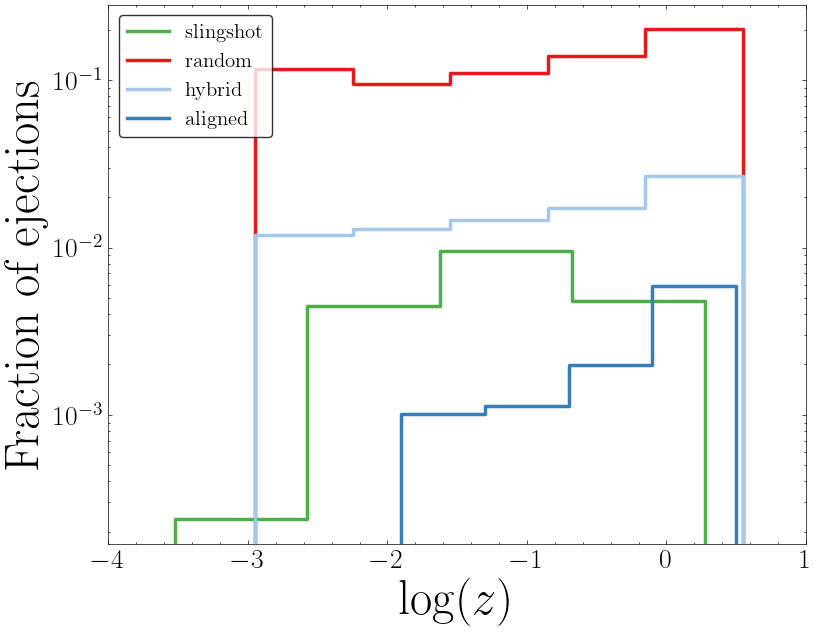

In [40]:
plt.figure(figsize=[9,7])
plt.step(bin_centers['slingshot'],np.mean(accumulated_fractions['slingshot'],axis=0),label="slingshot",linewidth =2.5,color=kick_colors['slingshot'])
plt.step(bin_centers['random'],np.mean(accumulated_fractions['random'],axis=0),label="random",linewidth =2.5,color=kick_colors['random'])
plt.step(bin_centers['hybrid'],np.mean(accumulated_fractions['hybrid'] ,axis=0),label="hybrid",linewidth =2.5,color=kick_colors['hybrid'])
plt.step(bin_centers['aligned'],np.mean(accumulated_fractions['aligned'],axis=0),label="aligned",linewidth =2.5,color=kick_colors['aligned'])
plt.xlim(-4,1)
plt.yscale("log")
plt.legend(fontsize=15, frameon=True, fancybox=True, framealpha=0.8, edgecolor="black",loc="upper left")
plt.xlabel("$\log (z)$",fontsize=35)
plt.ylabel("Fraction of ejections",fontsize=35)
plt.savefig("../Figures/ejection_fraction_for_total_population.pdf")

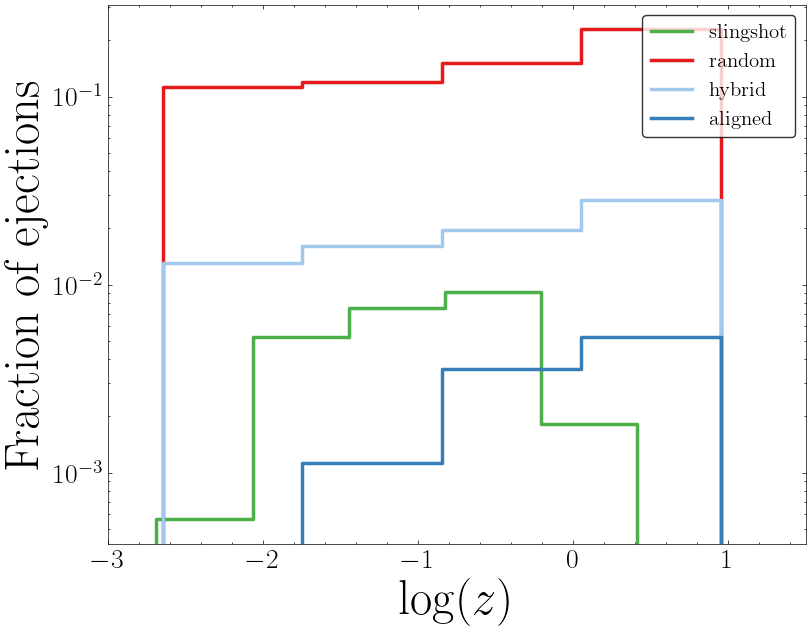

In [417]:
plt.figure(figsize=[9,7])
plt.step(bin_centers_sling,np.mean(accumulated_fraction_sling,axis=0),label="slingshot",linewidth =2.5,color=kick_colors['slingshot'])
plt.step(bin_centers_rand,np.mean(accumulated_fraction_rand,axis=0),label="random",linewidth =2.5,color=kick_colors['random'])
plt.step(bin_centers_hybrid,np.mean(accumulated_fraction_hybrid,axis=0),label="hybrid",linewidth =2.5,color=kick_colors['hybrid'])
plt.step(bin_centers_aligned,np.mean(accumulated_fraction_aligned,axis=0),label="aligned",linewidth =2.5,color=kick_colors['aligned'])
plt.xlim(-3,1.5)
plt.yscale("log")
plt.legend(fontsize=15, frameon=True, fancybox=True, framealpha=0.8, edgecolor="black",loc="upper right")
plt.xlabel("$\log (z)$",fontsize=35)
plt.ylabel("Fraction of ejections",fontsize=35)
plt.savefig("../Figures/ejection_fraction_for_total_population.pdf")

### Fraction of ejections total

In [8]:
fraction_random_eject = []
fraction_hybrid_eject = []
fraction_aligned_eject = []
fraction_slingshot_eject = []

for i in range(Nruns):
    # Total number of kicks for random spins
    N_mergers = np.sum(iso_bin.merger_mask)+np.sum(weak_tr.merger_mask)+np.sum(strong_tr[i].merger_mask)

    # Fraction of ejections for random spins
    fraction_random_eject.append(
        (np.sum(iso_bin.ejection_random_mask, axis=1) +
         np.sum(weak_tr.ejection_random_mask, axis=1) +
         np.sum(strong_tr[i].ejection_random_mask, axis=1)) /
        N_mergers
    )



    # Fraction of ejections for hybrid spins
    fraction_hybrid_eject.append(
        (np.sum(iso_bin.ejection_hybrid_mask, axis=1) +
         np.sum(weak_tr.ejection_hybrid_mask, axis=1) +
         np.sum(strong_tr[i].ejection_hybrid_mask, axis=1)) /
       N_mergers
    )



    # Fraction of ejections for aligned spins
    fraction_aligned_eject.append(
        (np.sum(iso_bin.ejection_aligned_mask, axis=1) +
         np.sum(weak_tr.ejection_aligned_mask, axis=1) +
         np.sum(strong_tr[i].ejection_aligned_mask, axis=1)) /
        N_mergers
    )



    # Fraction of ejections for slingshot kicks
    fraction_slingshot_eject.append(
        np.sum(strong_tr[i].ejection_slingshot_mask) / N_mergers
    )

# Output the results
print("In the total population")
print(f"Random ejection fraction: {np.mean(fraction_random_eject)*100:.4f} ± {np.std(fraction_random_eject)*100:.4f}")
print(f"Hybrid ejection fraction: {np.mean(fraction_hybrid_eject)*100:.4f} ± {np.std(fraction_hybrid_eject)*100:.4f}")
print(f"Aligned ejection fraction: {np.mean(fraction_aligned_eject)*100:.4f} ± {np.std(fraction_aligned_eject):.4f}")
print(f"Slingshot ejection fraction: {np.mean(fraction_slingshot_eject)*100:.4f} ± {np.std(fraction_slingshot_eject)*100:.4f}")

In the total population
Random ejection fraction: 14.0566 ± 0.4505
Hybrid ejection fraction: 1.7832 ± 0.1999
Aligned ejection fraction: 0.2283 ± 0.0006
Slingshot ejection fraction: 0.9952 ± 0.0144


In [9]:
fraction_random_eject = []
fraction_hybrid_eject = []
fraction_aligned_eject = []
fraction_slingshot_eject = []

for i in range(Nruns):
    # Total number of kicks for random spins
    N_mergers = 520

    # Fraction of ejections for random spins
    fraction_random_eject.append(
        (np.sum(strong_tr[i].ejection_random_mask, axis=1)) /
        N_mergers)

    # Fraction of ejections for hybrid spins
    fraction_hybrid_eject.append(
        (np.sum(strong_tr[i].ejection_hybrid_mask, axis=1)) /
       N_mergers
    )

    # Fraction of ejections for aligned spins
    fraction_aligned_eject.append(
        (np.sum(strong_tr[i].ejection_aligned_mask, axis=1)) /
        N_mergers
    )

    # Fraction of ejections for slingshot kicks
    fraction_slingshot_eject.append(
        np.sum((strong_tr[i].ejection_slingshot_mask)) / N_mergers)

# Output the results
print("In the strong triple population")
print(f"Random ejection fraction: {np.mean(fraction_random_eject)*100:.4f} ± {np.std(fraction_random_eject)*100:.4f}")
print(f"Hybrid ejection fraction: {np.mean(fraction_hybrid_eject)*100:.4f} ± {np.std(fraction_hybrid_eject)*100:.4f}")
print(f"Aligned ejection fraction: {np.mean(fraction_aligned_eject)*100:.4f} ± {np.std(fraction_aligned_eject):.4f}")
print(f"Slingshot ejection fraction: {np.mean(fraction_slingshot_eject)*100:.4f} ± {np.std(fraction_slingshot_eject)*100:.4f}")

In the strong triple population
Random ejection fraction: 9.3129 ± 1.1577
Hybrid ejection fraction: 0.9008 ± 0.3916
Aligned ejection fraction: 0.0612 ± 0.0010
Slingshot ejection fraction: 8.7346 ± 0.1281


### After accounting for ejections

In [113]:
iso_bin.bhid1 = iso_bin.binary_ids[:,0]
iso_bin.bhid2 = iso_bin.binary_ids[:,1]

weak_tr.bhid1 = weak_tr.bhid_inner[:,0]
weak_tr.bhid2 = weak_tr.bhid_inner[:,1]
weak_tr.bhid3 = weak_tr.bhid_outer[:,0]
weak_tr.bhid4 = weak_tr.bhid_outer[:,1]

for i in range(Nruns):
    strong_tr[i].bhid1 = strong_tr[i].bhid_inner[:,0]
    strong_tr[i].bhid2 = strong_tr[i].bhid_inner[:,1]
    strong_tr[i].bhid3 = strong_tr[i].bhid_outer[:,0]
    strong_tr[i].bhid4 = strong_tr[i].bhid_outer[:,1]

iso_invalid_merger_mask = np.zeros_like(iso_bin.bhid1, dtype=bool)
weak_triple_invalid_merger_mask = np.zeros_like(weak_tr.bhid1, dtype=bool)
strong_triple_invalid_merger_mask = np.zeros_like(strong_tr[0].bhid1, dtype=bool)

In [54]:
bhid_cols_in_iso_bins = {"bhid1","bhid2"}
bhid_cols_in_trips = {"bhid1","bhid2","bhid3","bhid4"}

In [55]:
iso_invalid_merger_masks = []

In [83]:
len(strong_tr[0].ejection_random_mask)

10

In [1]:
def find_invalid_mergers(strong_tr, weak_tr, iso_bin, ejection_mask_key, spin_i=0):
    """
    Returns boolean masks for invalid mergers in iso_bin, weak_tr, and strong_tr
    due to ejections, for a given spin realization.
    """
    # Prepare output masks
    iso_invalid = np.zeros_like(iso_bin.bhid1, dtype=bool)
    weak_invalid = np.zeros_like(weak_tr.bhid1, dtype=bool)
    strong_invalid = np.zeros_like(strong_tr.bhid1, dtype=bool)

    # Get ejection masks for this realization
    iso_eject = getattr(iso_bin, ejection_mask_key)[spin_i]
    weak_eject = getattr(weak_tr, ejection_mask_key)[spin_i]
    strong_eject = getattr(strong_tr, ejection_mask_key)[spin_i]

    # Helper: check if any BH in a system was ejected before merger
    def check_invalid(bhids1, t1, mask1, bhids2, t2, mask2):
        # For each system in 1, check if any BH matches a system in 2 that was ejected before t1
        for idx, bhid in enumerate(bhids1):
            matches = np.where(mask2 & (bhids2 == bhid))[0]
            if matches.size > 0:
                if np.any(t2[matches] < t1[idx]):
                    mask1[idx] = True

    # Check iso_bin vs iso_bin
    for bhid_col in ["bhid1", "bhid2"]:
        check_invalid(
            getattr(iso_bin, bhid_col), iso_bin.t_merge, iso_invalid,
            getattr(iso_bin, bhid_col), iso_bin.t_merge, iso_eject & iso_bin.merger_mask
        )
        # iso_bin vs weak_tr
        for bhid_tr_col in ["bhid1", "bhid2", "bhid3", "bhid4"]:
            check_invalid(
                getattr(iso_bin, bhid_col), iso_bin.t_merge, iso_invalid,
                getattr(weak_tr, bhid_tr_col), weak_tr.t_triple_form, weak_eject & weak_tr.merger_mask
            )
            # iso_bin vs strong_tr
            check_invalid(
                getattr(iso_bin, bhid_col), iso_bin.t_merge, iso_invalid,
                getattr(strong_tr, bhid_tr_col), strong_tr.t_triple_form, strong_eject & strong_tr.merger_mask
            )
            # iso_bin vs strong_tr slingshot
            check_invalid(
                getattr(iso_bin, bhid_col), iso_bin.t_merge, iso_invalid,
                getattr(strong_tr, bhid_tr_col), strong_tr.t_triple_form, strong_tr.ejection_slingshot_mask
            )

    # Repeat for weak_tr and strong_tr if needed (similar logic)
    # ... (for brevity, only iso_bin is shown, but you can repeat for weak_tr and strong_tr)

    return iso_invalid, weak_invalid, strong_invalid

In [100]:
def find_invalid_mergers(strong_tr,weak_tr,iso_bin,ejection_mask_key,spin_i=0):

    iso_invalid_merger_mask = np.zeros_like(iso_bin.bhid1, dtype=bool)
    weak_triple_invalid_merger_mask = np.zeros_like(weak_tr.bhid1, dtype=bool)
    strong_triple_invalid_merger_mask = np.zeros_like(strong_tr.bhid1, dtype=bool)
    
    iso_bin_eject_mask = getattr(iso_bin,ejection_mask_key)[spin_i]
    weak_tr_eject_mask = getattr(weak_tr,ejection_mask_key)[spin_i]
    strong_tr_eject_mask = getattr(strong_tr,ejection_mask_key)[spin_i]

    #iso binaries affected by "ejection_mask_key"

    for i, bhid_x in enumerate(bhid_cols_in_iso_bins):
        for j, bhid_y in enumerate(bhid_cols_in_iso_bins):
                common_occurrences_of_y_ejected_in_x = np.in1d(getattr(iso_bin,bhid_x),getattr(iso_bin,bhid_y)[iso_bin.merger_mask][iso_bin_eject_mask])
                bhidx_indices = np.where(common_occurrences_of_y_ejected_in_x)[0]
                if len(bhidx_indices) > 0:
                        bhidy_indices = np.array([np.where(getattr(iso_bin,bhid_y) == getattr(iso_bin,bhid_x)[i])[0][0] for i in bhidx_indices])
                        different_indices_mask = bhidx_indices != bhidy_indices
                        bhidx_t_merger = iso_bin.t_merge[bhidx_indices]
                        bhidy_t_merger = iso_bin.t_merge[bhidy_indices]
                        iso_invalid_merger_mask[bhidx_indices[different_indices_mask]] |= bhidy_t_merger[different_indices_mask] < bhidx_t_merger[different_indices_mask]
                else:
                        continue
                
        for k,bhid_z in enumerate(bhid_cols_in_trips):
            common_occurrences_of_z_ejected_in_x = np.in1d(getattr(iso_bin,bhid_x),getattr(weak_tr,bhid_z)[weak_tr.merger_mask][weak_tr_eject_mask])
            bhidx_indices = np.where(common_occurrences_of_z_ejected_in_x)[0]
            if len(bhidx_indices) > 0:
                bhidz_indices = np.array([np.where(getattr(weak_tr,bhid_z) == getattr(iso_bin,bhid_x)[i])[0][0] for i in bhidx_indices])
                different_indices_mask = bhidx_indices != bhidz_indices
                bhid1_t_merger = iso_bin.t_merge[bhidx_indices]
                bhid_wt_t_form = weak_tr.t_triple_form[bhidz_indices]
                iso_invalid_merger_mask[bhidx_indices[different_indices_mask]] |=  bhid_wt_t_form[different_indices_mask] < bhid1_t_merger[different_indices_mask]
                #weak_triple_invalid_merger_mask[bhidz_indices[different_indices_mask]] |= bhid1_t_merger[different_indices_mask] < bhid_wt_t_form[different_indices_mask]
            else:
                continue

            common_occurrences_of_strong_ejected_in_x = np.in1d(getattr(iso_bin,bhid_x),getattr(strong_tr,bhid_z)[strong_tr.merger_mask][strong_tr_eject_mask])
            bhidx_indices = np.where(common_occurrences_of_strong_ejected_in_x)[0]
            if len(bhidx_indices) > 0:
                bhidz_indices = np.array([np.where(getattr(strong_tr,bhid_z) == getattr(iso_bin,bhid_x)[i])[0][0] for i in bhidx_indices])
                different_indices_mask = bhidx_indices != bhidz_indices
                bhid1_t_merger = iso_bin.t_merge[bhidx_indices]
                bhid_st_t_form = strong_tr.t_triple_form[bhidz_indices]
                iso_invalid_merger_mask[bhidx_indices[different_indices_mask]] |=  bhid_st_t_form[different_indices_mask] < bhid1_t_merger[different_indices_mask]
                #strong_triple_invalid_merger_mask[bhidz_indices[different_indices_mask]] |= bhid1_t_merger[different_indices_mask] < bhid_wt_t_form[different_indices_mask]
            else:
                continue
            common_occurrences_of_sling_ejected_in_x = np.in1d(getattr(iso_bin,bhid_x),getattr(strong_tr,bhid_z)[strong_tr.ejection_slingshot_mask])
            bhidx_indices = np.where(common_occurrences_of_sling_ejected_in_x)[0]
            if len(bhidx_indices) > 0:
                bhidz_indices = np.array([np.where(getattr(strong_tr,bhid_z) == getattr(iso_bin,bhid_x)[i])[0][0] for i in bhidx_indices])
                different_indices_mask = bhidx_indices != bhidz_indices
                bhid1_t_merger = iso_bin.t_merge[bhidx_indices]
                bhid_st_t_form = strong_tr.t_triple_form[bhidz_indices]
                iso_invalid_merger_mask[bhidx_indices[different_indices_mask]] |=  bhid_st_t_form[different_indices_mask] < bhid1_t_merger[different_indices_mask]
    
    #weak triples affected by "ejection_mask_key"

    for i,bhid_x in enumerate(bhid_cols_in_trips):
        for j, bhid_y in enumerate(bhid_cols_in_iso_bins):
            common_occurrences_of_y_ejected_in_x = np.in1d(getattr(weak_tr,bhid_x),getattr(iso_bin,bhid_y)[iso_bin.merger_mask][iso_bin_eject_mask])
            bhidx_indices = np.where(common_occurrences_of_y_ejected_in_x)[0]
            
            if len(bhidx_indices) > 0:
                bhidy_indices = np.array([np.where(getattr(iso_bin,bhid_y) == getattr(weak_tr,bhid_x)[i])[0][0] for i in bhidx_indices])
                different_indices_mask = bhidx_indices != bhidy_indices
                bhidy_t_merger = iso_bin.t_merge[bhidy_indices]
                bhid_wt_t_form = weak_tr.t_triple_form[bhidx_indices]
                weak_triple_invalid_merger_mask[bhidx_indices[different_indices_mask]] |= bhidy_t_merger[different_indices_mask] < bhid_wt_t_form[different_indices_mask]

            else:
                continue

        for k, bhid_z in enumerate(bhid_cols_in_iso_bins):
            common_occurrences_of_y_ejected_in_x = np.in1d(getattr(weak_tr,bhid_x),getattr(weak_tr,bhid_z)[weak_tr.merger_mask][weak_tr_eject_mask])
            bhidx_indices = np.where(common_occurrences_of_y_ejected_in_x)[0]
            
            if len(bhidx_indices) > 0:
                bhidz_indices = np.array([np.where(getattr(weak_tr,bhid_z) == getattr(weak_tr,bhid_x)[i])[0][0] for i in bhidx_indices])
                different_indices_mask = bhidx_indices != bhidz_indices
                bhidz_t_form = weak_tr.t_triple_form[bhidz_indices]
                bhid_wt_t_form = weak_tr.t_triple_form[bhidx_indices]
                weak_triple_invalid_merger_mask[bhidx_indices[different_indices_mask]] |= bhidz_t_form[different_indices_mask] < bhid_wt_t_form[different_indices_mask]  
                
            else:
                continue
                
            common_occurrences_of_strong_ejected_in_x = np.in1d(getattr(weak_tr,bhid_x),getattr(strong_tr,bhid_z)[strong_tr.merger_mask][strong_tr_eject_mask])
            bhidx_indices = np.where(common_occurrences_of_strong_ejected_in_x)[0]
                
            if len(bhidx_indices) > 0:
                bhidz_indices = np.array([np.where(getattr(strong_tr,bhid_z) == getattr(weak_tr,bhid_x)[i])[0][0] for i in bhidx_indices])
                different_indices_mask = bhidx_indices != bhidz_indices
                bhid1_t_form = weak_tr.t_triple_form[bhidx_indices]
                bhid_wt_t_form =strong_tr.t_triple_form[bhidz_indices]
                weak_triple_invalid_merger_mask[bhidx_indices[different_indices_mask]] |= bhid1_t_form[different_indices_mask] < bhid_wt_t_form[different_indices_mask]
            
            else:
                continue

            common_occurrences_of_sling_ejected_in_x = np.in1d(getattr(weak_tr,bhid_x),getattr(strong_tr,bhid_z)[strong_tr.ejection_slingshot_mask])
            bhidx_indices = np.where(common_occurrences_of_sling_ejected_in_x)[0]
            
            if len(bhidx_indices) > 0:
                bhidz_indices = np.array([np.where(getattr(strong_tr,bhid_z) == getattr(weak_tr,bhid_x)[i])[0][0] for i in bhidx_indices])
                different_indices_mask = bhidx_indices != bhidz_indices
                bhid1_wt_t_form = weak_tr.t_triple_form[bhidx_indices]
                bhid_st_t_form = strong_tr.t_triple_form[bhidz_indices]
                weak_triple_invalid_merger_mask[bhidx_indices[different_indices_mask]] |=  bhid_st_t_form[different_indices_mask] < bhid1_wt_t_form[different_indices_mask]
            
            
    #strong triples affected by "gw-key"
                
    for i,bhid_x in enumerate(bhid_cols_in_trips):
        for j, bhid_y in enumerate(bhid_cols_in_iso_bins):
            
            common_occurrences_of_y_ejected_in_x = np.in1d(getattr(strong_tr,bhid_x),getattr(iso_bin,bhid_y)[iso_bin.merger_mask][iso_bin_eject_mask])
            bhidx_indices = np.where(common_occurrences_of_y_ejected_in_x)[0]

            if len(bhidx_indices) > 0:
                bhidy_indices = np.array([np.where(getattr(iso_bin,bhid_y) == getattr(strong_tr,bhid_x)[i])[0][0] for i in bhidx_indices])
                different_indices_mask = bhidx_indices != bhidy_indices
                bhidy_t_merger = iso_bin.t_merge[bhidy_indices]
                bhid_wt_t_form = strong_tr.t_triple_form[bhidx_indices]
                strong_triple_invalid_merger_mask[bhidx_indices[different_indices_mask]] |= bhidy_t_merger[different_indices_mask] < bhid_wt_t_form[different_indices_mask]

            else:
                continue

        for k, bhid_z in enumerate(bhid_cols_in_iso_bins):
            common_occurrences_of_y_ejected_in_x = np.in1d(getattr(strong_tr,bhid_x),getattr(weak_tr,bhid_z)[weak_tr.merger_mask][weak_tr_eject_mask])
            bhidx_indices = np.where(common_occurrences_of_y_ejected_in_x)[0]
            
            if len(bhidx_indices) > 0:
                bhidz_indices = np.array([np.where(getattr(weak_tr,bhid_z) == getattr(strong_tr,bhid_x)[i])[0][0] for i in bhidx_indices])
                different_indices_mask = bhidx_indices != bhidz_indices
                bhidz_t_form = weak_tr.t_triple_form[bhidz_indices]
                bhid_wt_t_form = strong_tr.t_triple_form[bhidx_indices]
                strong_triple_invalid_merger_mask[bhidx_indices[different_indices_mask]] |= bhidz_t_form[different_indices_mask] < bhid_wt_t_form[different_indices_mask]  
                
            else:
                continue
                
            common_occurrences_of_strong_ejected_in_x = np.in1d(getattr(strong_tr,bhid_x),getattr(strong_tr,bhid_z)[strong_tr.merger_mask][strong_tr_eject_mask])
            bhidx_indices = np.where(common_occurrences_of_strong_ejected_in_x)[0]
                
            if len(bhidx_indices) > 0:
                bhidz_indices = np.array([np.where(getattr(strong_tr,bhid_z) == getattr(strong_tr,bhid_x)[i])[0][0] for i in bhidx_indices])
                different_indices_mask = bhidx_indices != bhidz_indices
                bhid_wt_t_form = strong_tr.t_triple_form[bhidz_indices]
                bhid1_t_form = strong_tr.t_triple_form[bhidx_indices]
                strong_triple_invalid_merger_mask[bhidx_indices[different_indices_mask]] |= bhid1_t_form[different_indices_mask] < bhid_wt_t_form[different_indices_mask]
            
            else:
                continue

            common_occurrences_of_sling_ejected_in_x = np.in1d(getattr(strong_tr,bhid_x),getattr(strong_tr,bhid_z)[strong_tr.ejection_slingshot_mask])
            bhidx_indices = np.where(common_occurrences_of_sling_ejected_in_x)[0]
            
            if len(bhidx_indices) > 0:
                bhidz_indices = np.array([np.where(getattr(strong_tr,bhid_z) == getattr(strong_tr,bhid_x)[i])[0][0] for i in bhidx_indices])
                different_indices_mask = bhidx_indices != bhidz_indices
                bhid1_wt_t_form = strong_tr.t_triple_form[bhidx_indices]
                bhid_st_t_form = strong_tr.t_triple_form[bhidz_indices]
                strong_triple_invalid_merger_mask[bhidx_indices[different_indices_mask]] |=  bhid_st_t_form[different_indices_mask] < bhid1_wt_t_form[different_indices_mask]

            else:
                continue


    return iso_invalid_merger_mask,weak_triple_invalid_merger_mask,strong_triple_invalid_merger_mask

In [2]:
N_kick_realization = 10

In [3]:
def assign_invalid_merger_mask(strong_tr,weak_tr,iso_bin,spin_key):

    ejection_kick_mask = 'ejection_'+spin_key+'_mask'
    iso_inv_masks = []
    weak_inv_masks = []
    strong_inv_masks = []

    for i in range(N_kick_realization):
        realization_iso_masks = []   # Store iso masks for each realization
        realization_weak_masks = []  # Store weak masks for each realization
        realization_strong_masks = [] # Store strong masks for each realization
        
        for j in range(Nruns):
            # Find invalid mergers for the given realization and run
            iso_inv, weak_inv, strong_inv = find_invalid_mergers(
                strong_tr[j], weak_tr, iso_bin, ejection_kick_mask, spin_i=i
            )
            # Append masks for this run
            realization_iso_masks.append(iso_inv)
            realization_weak_masks.append(weak_inv)
            realization_strong_masks.append(strong_inv)
        
        # Append realization masks to the main lists
        iso_inv_masks.append(realization_iso_masks)
        weak_inv_masks.append(realization_weak_masks)
        strong_inv_masks.append(realization_strong_masks)

    # Convert the nested lists into 3D arrays if necessary
    iso_inv_masks = np.array(iso_inv_masks)  # Requires numpy
    weak_inv_masks = np.array(weak_inv_masks)
    strong_inv_masks = np.array(strong_inv_masks)

    setattr(iso_bin,spin_key+'_invalid_mask', iso_inv_masks)
    setattr(weak_tr,spin_key+'_invalid_mask', weak_inv_masks)
    setattr(strong_tr[0],spin_key+'_invalid_mask',strong_inv_masks)

In [5]:
assign_invalid_merger_mask(strong_tr,weak_tr,iso_bin,'random')
assign_invalid_merger_mask(strong_tr,weak_tr,iso_bin,'hybrid')
assign_invalid_merger_mask(strong_tr,weak_tr,iso_bin,'aligned')

NameError: name 'strong_tr' is not defined

In [3]:
assign_invalid_merger_mask(strong_tr,weak_tr,iso_bin,'random')
assign_invalid_merger_mask(strong_tr,weak_tr,iso_bin,'hybrid')
assign_invalid_merger_mask(strong_tr,weak_tr,iso_bin,'aligned')

NameError: name 'strong_tr' is not defined

In [167]:
tot_invalid_merger_fraction = []
for i in range(N_kick_realization):
    realization_tot_invalid = []
    for j in range(Nruns):
        iso_invalid_random = np.sum((iso_bin.merger_mask) & (iso_bin.random_invalid_mask[i][j]))
        iso_invalid_hybrid = np.sum((iso_bin.merger_mask) & (iso_bin.hybrid_invalid_mask[i][j]))
        iso_invalid_aligned = np.sum((iso_bin.merger_mask) & (iso_bin.aligned_invalid_mask[i][j]))
        iso_mergers = np.sum(iso_bin.merger_mask)

        weak_invalid = np.sum((weak_tr.merger_mask) & (weak_tr.random_invalid_mask[i][j]))
        weak_tr_mergers = np.sum(weak_tr.merger_mask)

        # Handle `strong_tr` assuming it's a list of objects
        strong_invalid = np.sum((strong_tr[j].merger_mask) & (strong_tr[0].random_invalid_mask[i][j]))
        strong_tr_mergers = np.sum(strong_tr[j].merger_mask)

        realization_tot_invalid.append((iso_invalid + weak_invalid + strong_invalid)/(iso_mergers+weak_tr_mergers+strong_tr_mergers))
        #realization_tot_invalid.append(np.sum((iso_bin.merger_mask)&(iso_bin.random_invalid_mask[i][j]))+np.sum((weak_tr.merger_mask)&(weak_tr.random_invalid_mask[i][j])))+ np.sum((strong_tr[j].merger_mask)&(strong_tr[0].random_invalid_mask[i][j]))
    tot_invalid_merger_fraction.append(realization_tot_invalid)

In [177]:
tot_invalid_merger_fraction = {
    'random': [],
    'hybrid': [],
    'aligned': []
}

for i in range(N_kick_realization):
    # Initialize lists to store results for each realization
    realization_tot_invalid_random = []
    realization_tot_invalid_hybrid = []
    realization_tot_invalid_aligned = []

    for j in range(Nruns):
        # For `iso_bin` mergers
        iso_invalid_random = np.sum((iso_bin.merger_mask) & (iso_bin.random_invalid_mask[i][j]))
        iso_invalid_hybrid = np.sum((iso_bin.merger_mask) & (iso_bin.hybrid_invalid_mask[i][j]))
        iso_invalid_aligned = np.sum((iso_bin.merger_mask) & (iso_bin.aligned_invalid_mask[i][j]))
        iso_mergers = np.sum(iso_bin.merger_mask)

        # For `weak_tr` mergers
        weak_invalid_random = np.sum((weak_tr.merger_mask) & (weak_tr.random_invalid_mask[i][j]))
        weak_invalid_hybrid = np.sum((weak_tr.merger_mask) & (weak_tr.hybrid_invalid_mask[i][j]))
        weak_invalid_aligned = np.sum((weak_tr.merger_mask) & (weak_tr.aligned_invalid_mask[i][j]))
        weak_tr_mergers = np.sum(weak_tr.merger_mask)

        # For `strong_tr` mergers (assuming `strong_tr` is a list)
        strong_invalid_random = np.sum((strong_tr[j].merger_mask) & (strong_tr[0].random_invalid_mask[i][j]))
        strong_invalid_hybrid = np.sum((strong_tr[j].merger_mask) & (strong_tr[0].hybrid_invalid_mask[i][j]))
        strong_invalid_aligned = np.sum((strong_tr[j].merger_mask) & (strong_tr[0].aligned_invalid_mask[i][j]))
        strong_tr_mergers = np.sum(strong_tr[j].merger_mask)

        # Calculate invalid fractions for random, hybrid, and aligned
        total_mergers = iso_mergers + weak_tr_mergers + strong_tr_mergers
        realization_tot_invalid_random.append((iso_invalid_random + weak_invalid_random + strong_invalid_random) / total_mergers)
        realization_tot_invalid_hybrid.append((iso_invalid_hybrid + weak_invalid_hybrid + strong_invalid_hybrid) / total_mergers)
        realization_tot_invalid_aligned.append((iso_invalid_aligned + weak_invalid_aligned + strong_invalid_aligned) / total_mergers)

    # Append results for this realization to the main lists
    tot_invalid_merger_fraction['random'].append(realization_tot_invalid_random)
    tot_invalid_merger_fraction['hybrid'].append(realization_tot_invalid_hybrid)
    tot_invalid_merger_fraction['aligned'].append(realization_tot_invalid_aligned)

In [190]:
print(f"{np.mean(tot_invalid_merger_fraction['random'])*100:.1f}% of mergers won't happen due to GW random + slingshot ejections")
print(f"{np.mean(tot_invalid_merger_fraction['hybrid'])*100:.1f}% of mergers won't happen due to GW hybrid + slingshot ejections")
print(f"{np.mean(tot_invalid_merger_fraction['aligned'])*100:.1f}% of mergers won't happen due to GW aligned + slingshot ejections")

5.6% of mergers won't happen due to GW random + slingshot ejections
1.6% of mergers won't happen due to GW hybrid + slingshot ejections
0.2% of mergers won't happen due to GW aligned + slingshot ejections


In [201]:
tot_merger_rate_after_ejection = {
    'random': [],
    'hybrid': [],
    'aligned': []
}

for i in tqdm(range(N_kick_realization),desc="calculating all merger rates after ejections for all spin realizations"):
    # Initialize lists to store results for each realization
    realization_tot_merger_rate_random = []
    realization_tot_merger_rate_hybrid = []
    realization_tot_merger_rate_aligned = []

    for j in range(Nruns):
        # For `iso_bin` mergers
        iso_random = mr.merger_rate_find(iso_bin.z_merger[(iso_bin.merger_mask) & (~iso_bin.random_invalid_mask[i][j])],zbinsize=0.2, zmax=7)[1]
        iso_hybrid = mr.merger_rate_find(iso_bin.z_merger[(iso_bin.merger_mask) & (~iso_bin.hybrid_invalid_mask[i][j])],zbinsize=0.2, zmax=7)[1]
        iso_aligned = mr.merger_rate_find(iso_bin.z_merger[(iso_bin.merger_mask) & (~iso_bin.aligned_invalid_mask[i][j])],zbinsize=0.2, zmax=7)[1]

        weak_tr_random = mr.merger_rate_find(weak_tr.z_merger[(weak_tr.merger_mask) & (~weak_tr.random_invalid_mask[i][j])],zbinsize=0.2, zmax=7)[1]
        weak_tr_hybrid = mr.merger_rate_find(weak_tr.z_merger[(weak_tr.merger_mask) & (~weak_tr.hybrid_invalid_mask[i][j])],zbinsize=0.2, zmax=7)[1]
        weak_tr_aligned = mr.merger_rate_find(weak_tr.z_merger[(weak_tr.merger_mask) & (~weak_tr.aligned_invalid_mask[i][j])],zbinsize=0.2, zmax=7)[1]


        strong_random = mr.merger_rate_find(strong_tr[i].z_triple_merger[(strong_tr[i].merger_mask) & (~strong_tr[0].random_invalid_mask[i][j])],zbinsize=0.2, zmax=7)[1]
        strong_hybrid = mr.merger_rate_find(strong_tr[i].z_triple_merger[(strong_tr[i].merger_mask) & (~strong_tr[0].hybrid_invalid_mask[i][j])],zbinsize=0.2, zmax=7)[1]
        strong_aligned = mr.merger_rate_find(strong_tr[i].z_triple_merger[(strong_tr[i].merger_mask) & (~strong_tr[0].aligned_invalid_mask[i][j])],zbinsize=0.2, zmax=7)[1]

        realization_tot_merger_rate_random.append(iso_random + weak_tr_random + strong_random)
        realization_tot_merger_rate_hybrid.append(iso_hybrid + weak_tr_hybrid + strong_hybrid)
        realization_tot_merger_rate_aligned.append(iso_aligned + weak_tr_aligned + strong_aligned)

    tot_merger_rate_after_ejection['random'].append(realization_tot_merger_rate_random)
    tot_merger_rate_after_ejection['hybrid'].append(realization_tot_merger_rate_hybrid)
    tot_merger_rate_after_ejection['aligned'].append(realization_tot_merger_rate_aligned)


calculating all merger rates after ejections for all spin realizations: 100%|██████████| 10/10 [3:13:36<00:00, 1161.70s/it] 


In [210]:
print(f"The merger rate after accounting for random ejections : {np.mean(tot_merger_rate_after_ejection['random']):.3f} yr^-1")
print(f"The merger rate after accounting for hybrid ejections : {np.mean(tot_merger_rate_after_ejection['aligned']):.4f} yr^-1")
print(f"The merger rate after accounting for aligned ejections : {np.mean(tot_merger_rate_after_ejection['hybrid']):.4f} yr^-1")

The merger rate after accounting for random ejections : 0.387 yr^-1
The merger rate after accounting for hybrid ejections : 0.4018 yr^-1
The merger rate after accounting for aligned ejections : 0.3991 yr^-1


In [200]:
mr.merger_rate_find(iso_bin.z_merger[(iso_bin.merger_mask)& (~iso_bin.random_invalid_mask[0][0])],zbinsize=0.2, zmax=7)[1]

0.35346643679945733

In [196]:
np.mean(tot_merger_rate_after_ejection['random'])

0.015520496692700664

In [355]:
tot_merger_rate = []
tot_merger_rate_after_ejec = []

for i in range(Nruns):
    weak_mr = mr.merger_rate_find(weak_tr.z_merger[(weak_tr.merger_mask)],zbinsize=0.2, zmax=7)[1]
    iso_mr = mr.merger_rate_find(iso_bin.z_merger[(iso_bin.merger_mask)],zbinsize=0.2, zmax=7)[1]
    strong_mr = mr.merger_rate_find(strong_tr[i].z_triple_merger[(strong_tr[i].merger_mask)],zbinsize=0.2, zmax=7)[1]

    tot_merger_rate.append(iso_mr+strong_mr+weak_mr)
    
    iso_inv_mask,weak_inv_mask,strong_inv_mask = Tr.find_invalid_mergers(strong_tr[0],weak_tr,iso_bin,"random")

    weak_mr = mr.merger_rate_find(weak_tr.z_merger[(weak_tr.merger_mask)&(~weak_inv_mask)],zbinsize=0.2, zmax=7)[1]
    iso_mr = mr.merger_rate_find(iso_bin.z_merger[(iso_bin.merger_mask)&(~iso_inv_mask)],zbinsize=0.2, zmax=7)[1]
    strong_mr = mr.merger_rate_find(strong_tr[i].z_triple_merger[(strong_tr[i].merger_mask)&(~strong_inv_mask)],zbinsize=0.2, zmax=7)[1]

    tot_merger_rate_after_ejec.append(iso_mr+strong_mr+weak_mr)


In [349]:
weak_mr = mr.merger_rate_find(weak_tr.z_merger[(weak_tr.merger_mask)],zbinsize=0.2, zmax=7)[1]
iso_mr = mr.merger_rate_find(iso_bin.z_merger[(iso_bin.merger_mask)],zbinsize=0.2, zmax=7)[1]
strong_mr = mr.merger_rate_find(strong_tr[0].z_triple_merger[(strong_tr[0].merger_mask)],zbinsize=0.2, zmax=7)[1]